In [1]:
from google.colab import drive
drive.mount('/content/drive' )

Mounted at /content/drive


In [3]:
import cv2
import os
import numpy as np # linear algebra
from tqdm import tqdm
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections
from sklearn.preprocessing import LabelBinarizer

In [ ]:
from __future__ import print_function
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
import os


In [10]:

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings
from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
import keras.backend as K

In [ ]:
!unzip urdu\ numb.zip -d Dataset

In [4]:
def load_labels(myDir):
    labels=[]
    fileList = glob.glob(myDir)
   
    for fname in fileList:
        curLabel = fname.split("/")
        # print(curLabel[2])
        labels.append(curLabel[2])
    return np.asarray(labels)
        

def load_data(myDir):
    fileList = glob.glob(myDir)
    data=[]   
    for fname in fileList:
      img1 = cv2.imread(fname)
      x = cv2.resize(img1,(32,32), interpolation = cv2.INTER_AREA)
      data.append(x)
    return data

In [5]:
import glob
myDir ="Dataset/*/*/*.*"
labels = load_labels(myDir)
data = load_data(myDir)
data = np.array(data, dtype='float32')/255.
data.shape


(9874, 32, 32, 3)

In [6]:
labels = np.array(labels)
labels

array(['4', '4', '4', ..., '3', '3', '3'], dtype='<U1')

In [7]:

labels = to_categorical(labels, 10)
labels.shape

(9874, 10)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.10, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=42)

<h2> Adaptive Learning Rate

In [20]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

<h2> CBAM and Squeeze & Excitation Block

In [21]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		
	

Set 'attention_module' to 'cbam_block' if one want to use Convolution Based Attention Module with Renset V1. Set 'attention_module' to 'se_block' to use Squeeze and Excitation block. And set 'attention_module' to 'None' if you want to use the ResNet V1 with original setting.

In [29]:
# Training parameters
batch_size = 64
epochs = 50
data_augmentation = False
num_classes = 10
subtract_pixel_mean = True  # Subtracting pixel mean improves accuracy
base_model = 'resnet'

# Choose what attention_module to use: cbam_block / se_block / None
attention_module = 'cbam_block'
model_type = base_model if attention_module==None else base_model+'_'+attention_module

In [30]:
input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [31]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test_mean = np.mean(x_test, axis=0)
    x_test -= x_test_mean

<h2> ResNet V1

In [32]:
"""
ResNet v1
This is a revised implementation from Cifar10 ResNet example in Keras:
(https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py)
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf
"""

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10, attention_module=None):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            # attention_module
            if attention_module is not None:
                y = attach_attention_module(y, attention_module)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

<h2> Compiling and Training Model

In [33]:
depth = 20 # For ResNet, specify the depth (e.g. ResNet20: depth=20)
model = resnet_v1(input_shape=input_shape, depth=depth, attention_module=attention_module)


Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 32, 32, 16)   64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 32, 32, 16)   0           batch_normalization_38[0][0]     
______________________________________________________________________

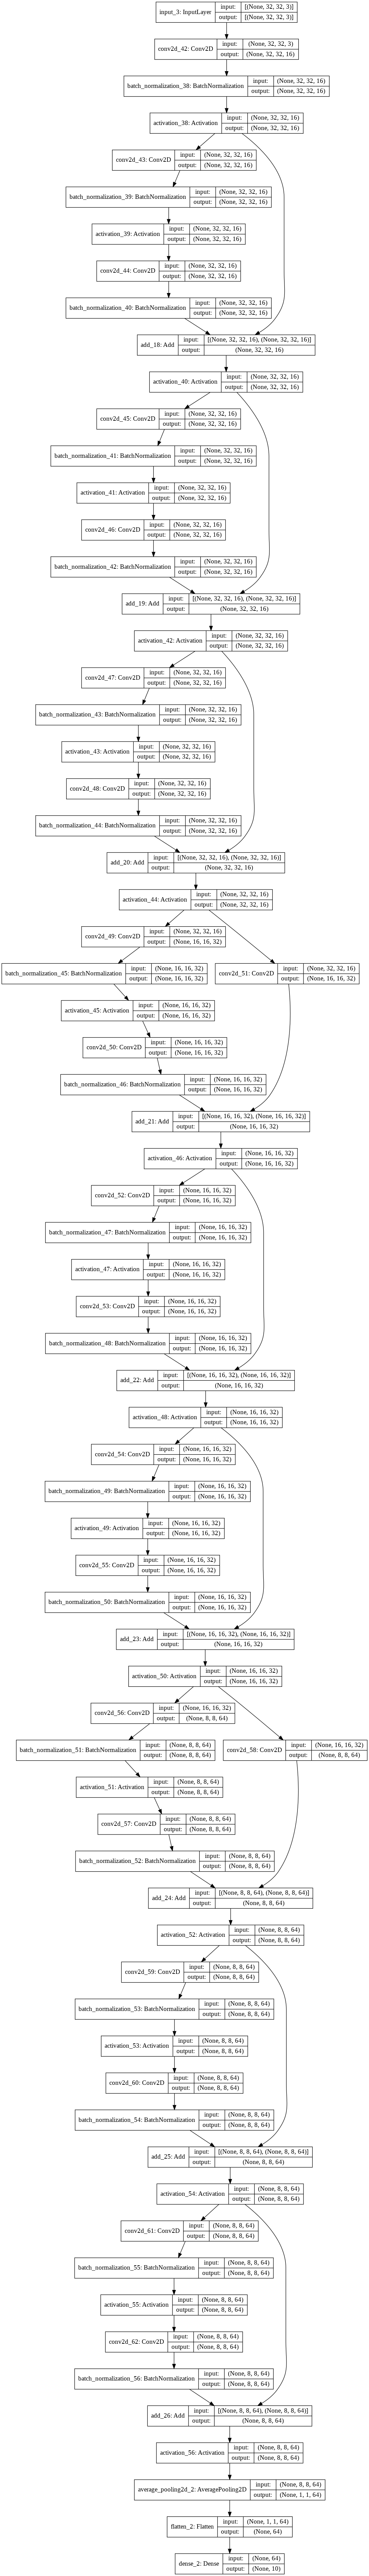

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
from keras.utils.vis_utils import plot_model
print(model_type)
plot_model(model, to_file=model_type+'.png', show_shapes=True, show_layer_names=True)

Epoch 1/50
Learning rate:  0.001
104/104 [==============================] - 102s 956ms/step - loss: 1.3517 - accuracy: 0.6999 - val_loss: 2.3274 - val_accuracy: 0.5477
Epoch 2/50
Learning rate:  0.001
104/104 [==============================] - 98s 943ms/step - loss: 0.2655 - accuracy: 0.9672 - val_loss: 0.5946 - val_accuracy: 0.8447
Epoch 3/50
Learning rate:  0.001
104/104 [==============================] - 100s 966ms/step - loss: 0.2036 - accuracy: 0.9839 - val_loss: 0.4803 - val_accuracy: 0.8813
Epoch 4/50
Learning rate:  0.001
104/104 [==============================] - 100s 960ms/step - loss: 0.1779 - accuracy: 0.9918 - val_loss: 0.2537 - val_accuracy: 0.9656
Epoch 5/50
Learning rate:  0.001
104/104 [==============================] - 97s 930ms/step - loss: 0.1642 - accuracy: 0.9949 - val_loss: 0.2646 - val_accuracy: 0.9623
Epoch 6/50
Learning rate:  0.001
104/104 [==============================] - 99s 954ms/step - loss: 0.1637 - accuracy: 0.9909 - val_loss: 0.5979 - val_accuracy: 0.

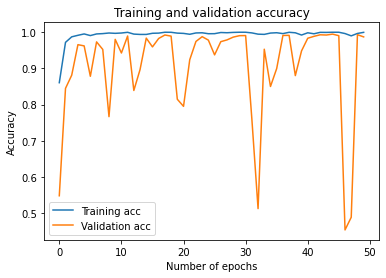

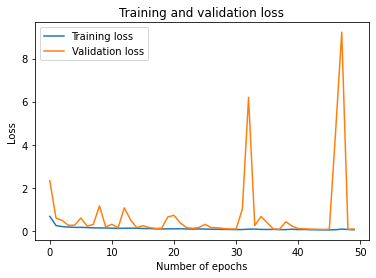

In [35]:

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'drive/MyDrive/CBAMProject/Resnet_v2/saved_models')
model_name = 'urdu_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)



lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc))
# epochs = range(0, 85)

plt.plot(epochs, acc,  label='Training acc')
plt.plot(epochs, val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.savefig('drive/MyDrive/CBAMProject/Resnet_v2/saved_models/Acc_%s.{epoch:03d}.png', bbox_inches='tight')
plt.figure();

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('drive/MyDrive/CBAMProject/Resnext_none/saved_models/Loss_%s.{epoch:03d}.png', bbox_inches='tight')

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


<h2> Evaluationg Model

In [ ]:
from keras.models import load_model

model = load_model('drive/MyDrive/CBAMProject/saved_models/urdu_resnet20_cbam_block_model.010.h5')

In [36]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


102/102 [==============================] - 11s 111ms/step - loss: 0.0875 - accuracy: 0.9871
Test loss: 0.08752839267253876
Test accuracy: 0.9871125817298889


<h2> Visualizing Feature Map

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 32, 32, 16)   64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 32, 32, 16)   0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

In [38]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('activation_56').output])

In [52]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# load image with size 224 x 224
img = load_img('33.bmp', target_size=(32,32))

# convert img to array
img = img_to_array(img)

In [53]:
img.shape

(32, 32, 3)

In [54]:
from numpy import expand_dims

img = expand_dims(img, axis=0)
ouputs = model.predict(img)

model_outputs = ouputs[0]
attention_outputs = ouputs[1]

In [55]:
attention_outputs.shape

(1, 8, 8, 64)

In [57]:
# img = preprocess_input(img)
feature_maps = model.predict(img)

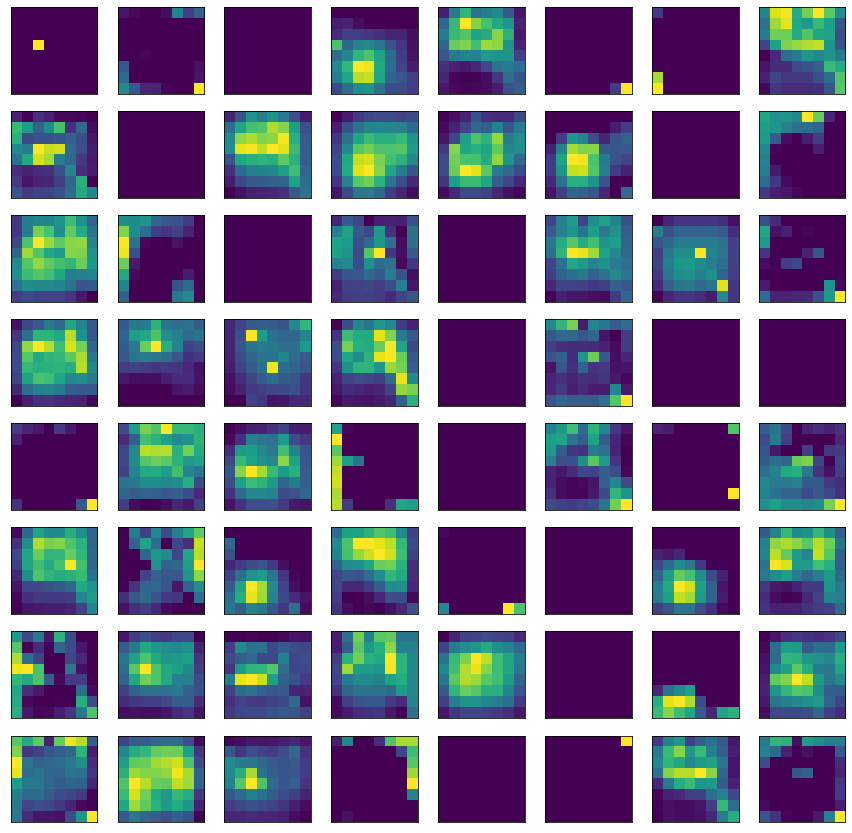

In [58]:
from matplotlib import pyplot
f = pyplot.figure()
f.set_size_inches(15,15)
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(attention_outputs[0, :, :, ix-1])
		ix += 1
# show the figure
pyplot.show()

<h2> Confusion Matrix and Classification Report

In [91]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
from skimage import feature
from skimage import exposure
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import pandas as pd


In [92]:
predY = model.predict(x_test)

In [95]:
predY = predY[0].argmax(1)

In [117]:
y_test = y_test.argmax(1)

In [128]:

print(classification_report(y_test,predY, zero_division=0))
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test,predY)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       481
           1       1.00      0.99      0.99       441
           2       1.00      0.90      0.94       292
           3       0.94      1.00      0.97       332
           4       0.92      0.99      0.95       145
           5       0.99      1.00      0.99       247
           6       1.00      0.99      0.99       271
           7       1.00      1.00      1.00       282
           8       1.00      1.00      1.00       407
           9       1.00      1.00      1.00       361

    accuracy                           0.99      3259
   macro avg       0.98      0.99      0.98      3259
weighted avg       0.99      0.99      0.99      3259


Accuracy: 0.99



In [129]:
actual = pd.Series(y_test,name='Actual')
predicted = pd.Series(predY,name='Predicted')
confusion_matrix = pd.crosstab(actual, predicted, margins=True)

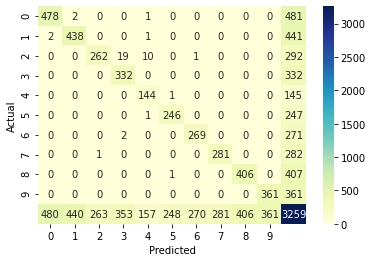

In [130]:
import seaborn as sns
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] # default sorting of classes is aplanumeric
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='d', cmap="YlGnBu")
